In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## 1. Precipitation analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# 1) find the lastest date, -- so we could the exact months of the last 12 months
last_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#### store the last date
last_date = last_date_result[0]

#### conver the string of date into date format
last_date_format = dt.datetime.strptime(last_date , '%Y-%m-%d')

In [12]:
# 2) Calculate the date 1 year ago from the last data point in the database

#### import relativedelta to find the date of 12 month before the last_date
from dateutil.relativedelta import relativedelta

Date_12months = last_date_format + relativedelta(months=-12)
Date_12months

datetime.datetime(2016, 8, 23, 0, 0)

In [98]:
# 3) filter and store the data within 12 month
#### only retrieve data and precipitation
Last_12Month = session.query(Measurement.date,func.sum(Measurement.prcp).label("precipitation")).group_by(Measurement.date).\
               filter(Measurement.date >= Date_12months).all()

In [104]:
# 4) Perform a query to retrieve the data and precipitation scores
#### store the data into pd dataframe
new_list = []
for row in Last_12Month:
    new_list.append(row)
df = pd.DataFrame(new_list)
df.head()

,date,precipitation
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10


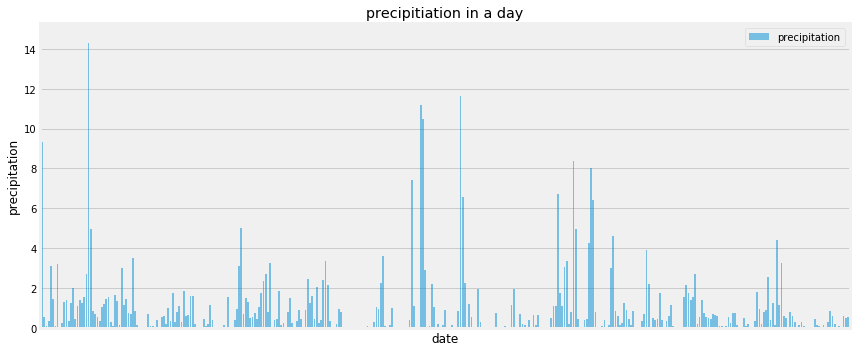

In [105]:
# 5) Use Pandas Plotting with Matplotlib to plot the data
x_axis = df["date"]
y_axis = df["precipitation"]

plt.figure(figsize=(12,5))
plt.bar(x_axis,y_axis,  alpha = 0.5, label="precipitation", align = "center")
plt.title("precipitiation in a day")
plt.xlabel("date")
plt.ylabel("precipitation")
plt.xlim(-0.75,len(x_axis)-0.25)
plt.ylim(0,max(y_axis)+1)
plt.grid()
plt.legend()
plt.xticks([])
plt.grid(True,which='major', axis='both')
plt.tight_layout()

plt.show()

In [110]:
# 6) Use Pandas to calcualte the summary statistics for the precipitation data

#### query all the data within 12 month but without groupby
no_group = session.query(Measurement.date,Measurement.prcp).\
               filter(Measurement.date >= Date_12months).all()

#### store the data into data frame
no_group_list = []
for row in no_group:
    no_group_list.append(row)
no_group_df = pd.DataFrame(no_group_list)
no_group_df.count()

# Use Pandas to calcualte the summary statistics for the precipitation data
no_group_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## 2. station analysis(try 1)--I use Pandas to query the station "number" and "frequency"

In [24]:
# 1) Design a query to show how many stations are available in this dataset?

#### store the data in dataframework
measurement_db = session.query(Measurement).all()
measurement_db_list = []

for row in measurement_db:
    measurement_db_list.append(row.__dict__)
    
#### query the number of station  
measurement_df = pd.DataFrame(measurement_db_list)
measurement_df["station"].nunique()

9

In [25]:
# 2) What are the most active stations? (i.e. what stations have the most rows)?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

measurement_df["station"].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

## 2. station analysis(try 2)--I use sqlalchemy to query the station number

In [26]:
# 1) Design a query to show how many stations are available in this dataset?

#### import distinct to count the unique station
from sqlalchemy import distinct

#### count distinct "name" values
station_num = session.query(func.count(distinct(Measurement.station))).all()
station_num

[(9)]

In [27]:
# 2) What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_freq = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# 3) Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

#### store the ID of most active station
station_most = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_most_id = station_most[0]

#### store the query of the most active station
station_most_q = session.query(Measurement.tobs).filter(Measurement.station == station_most_id)

#### find the highest T
highest_T = station_most_q.order_by(Measurement.tobs.desc()).first()
print("The highest T in the most active station is",highest_T[0])

#### find the lowest T
lowest_T = station_most_q.order_by(Measurement.tobs.asc()).first()
print("The lowest T in the most active station is", lowest_T[0])

#### find the average T
ave_T = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_most_id).all()
print("The averaged T in the most active station is",ave_T[0][0])

The highest T in the most active station is 85.0
The lowest T in the most active station is 54.0
The averaged T in the most active station is 71.66378066378067


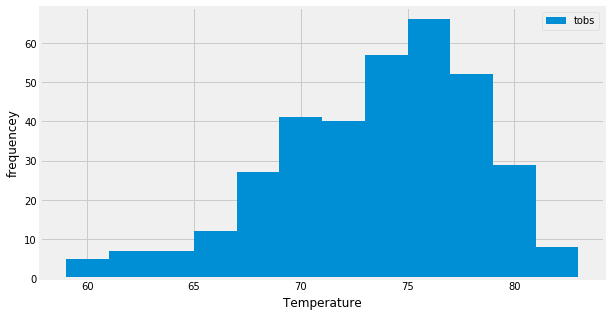

In [50]:
# 3) Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#### here, we need to filter the most active station in Last_12Month
from sqlalchemy import and_
most_Last_12Month_q = session.query(Measurement).filter(and_(Measurement.station == station_most_id,Measurement.date >= Date_12months)).all()

#### store the data into dataframe
most_Last_12Month_list = []

for row in most_Last_12Month_q:
    most_Last_12Month_list.append(row.__dict__)
    
most_Last_12Month_df = pd.DataFrame(most_Last_12Month_list)

#### plot the results as a histogram
plt.figure(figsize=(9,5))
plt.hist(most_Last_12Month_df["tobs"], bins=12)
labels= ["tobs"]
plt.legend(labels)
plt.xlabel('Temperature')
plt.ylabel('frequencey')
plt.grid(True)
plt.show()

## Optional Challenge Assignment
# 3. Temerature analysis 

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
start_date = input("The start date (YYYY-MM-DD) of your trip:")
end_date = input("The end date (YYYY-MM-DD) of your trip:")

The start date (YYYY-MM-DD) of your trip: 2017-02-02
The end date (YYYY-MM-DD) of your trip: 2017-02-15


In [53]:
temp_info = calc_temps(start_date,end_date)
temp_info

[(59.0, 69.85714285714286, 80.0)]

In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TMIN = temp_info[0][0]
TAVE = temp_info[0][1]
TMAX = temp_info[0][2]
print("the lowest temperature during your trip is", TMIN)
print("the averaged temperature during your trip is", TAVE)
print("the highest temperature during your trip is", TMAX)

the lowest temperature during your trip is 59.0
the averaged temperature during your trip is 69.85714285714286
the highest temperature during your trip is 80.0


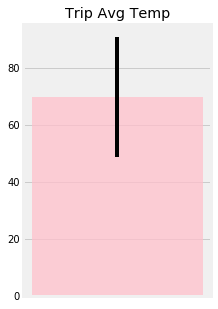

In [55]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#### plot the results as a histogram
plt.figure(figsize=(3,5))
plt.bar(1, TAVE,color = "pink", alpha = 0.75, yerr=TMAX-TMIN,align = "center")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.show()

In [56]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precipitation_station = session.query(Station.station,Station.name,Measurement.prcp,Station.latitude,Station.longitude, Station.elevation).filter(Station.station == Measurement.station).group_by(Measurement.station).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).order_by(Measurement.prcp.desc()).all()
precipitation_station

[('USC00513117', 'KANEOHE 838.1, HI US', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.0,
  21.33556,
  -157.71139,
  19.5)]

## 4. Calculate the rainfall per weather station 

In [57]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [58]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = input("The start date (MM-DD) of your trip:")
end_date = input("The end date (MM-DD) of your trip:")

The start date (MM-DD) of your trip: 01-01
The end date (MM-DD) of your trip: 01-07


In [59]:
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
no_year = func.strftime("%m-%d", Measurement.date)
trip_range = session.query(no_year).filter(no_year>= start_date).\
               filter(no_year<= end_date).group_by(no_year).all()

In [60]:
dates = []
for day in trip_range:
    dates.append(day[0])
    
date_df = pd.DataFrame(dates)
date_df_rename = date_df.rename(columns={0:"date"})
date_df_rename

,date
0,01-01
1,01-02
2,01-03
3,01-04
4,01-05
5,01-06
6,01-07


In [61]:
#normals = []
TMIN = []
TMAX = []
TAVG = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in date_df_rename["date"]:
    normals = daily_normals(day)
    TMIN.append(normals[0][0])
    TAVG.append(normals[0][1])
    TMAX.append(normals[0][2])
    
df = pd.DataFrame({"tmin":TMIN,"tavg":TAVG,"tmax":TMAX})
df["date"] = date_df_rename["date"]

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_final = df.set_index("date")


#normals_df_rename = normals_df.rename(columns={0:"Temperature_info"})
df_final.head()

,tmin,tavg,tmax
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0


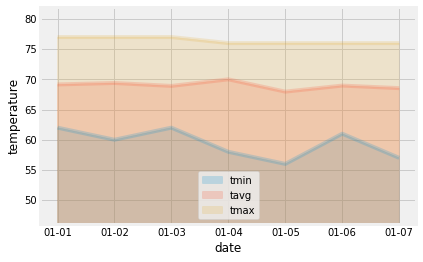

In [62]:
# Plot the daily normals as an area plot with `stacked=False`
x = df_final.index
y1 = df_final["tmin"]
y2 = df_final["tavg"]
y3 = df_final["tmax"]

#y = np.vstack([y1, y2, y3])

labels = ["tmin","tavg","tmax"]
colors = ["li"]

df_final.plot.area(stacked=False, alpha=0.2)
plt.legend(loc='lower center')
plt.xlabel("date")
plt.ylabel("temperature")
plt.ylim(min(y1)-10,max(y3)+5)

tick_location = [value for value in np.arange(0,len(x))]
plt.xticks(tick_location,x)

plt.show()